In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import datetime as dt
import os

from sklearn.model_selection import train_test_split
from IPython.display import display
from matplotlib import pyplot as plt
import pandas as pd

import gobbli
from gobbli.augment.wordnet import WordNet
from gobbli.augment.word2vec import Word2Vec
from gobbli.augment.bert import BERTMaskedLM
from gobbli.dataset.imdb import IMDBDataset
from gobbli.model.fasttext import FastText
from gobbli.model.bert import BERT

import benchmark
benchmark.init_benchmark_env()

In [2]:
ds = IMDBDataset.load()
X_train_valid, X_test = ds.X_train(), ds.X_test()
y_train_valid, y_test = ds.y_train(), ds.y_test()

In [3]:
def analyze_all_results(model_cls, all_results_metrics, percent_multipliers):
    all_metrics = pd.DataFrame([{
        "percent": p,
        "multiplier": m,
        **r,
    } for (p, m), r in zip(percent_multipliers, all_results_metrics)])
    
    display(all_metrics)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for key, grp in all_metrics.groupby("multiplier"):
        grp.plot(x="percent", y="Weighted F1 Score", kind="line",
                 label=f"{key}x augmentation", ax=ax)
    
    plt.xlabel("Proportion of Data Used")
    plt.ylabel("Weighted F1 Score")
    plt.title(f"Model Performance by Proportion of Data Used - {model_cls.__name__}")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    plt.show()

def evaluate_model(model_cls, X, y, param_grid, percent_multipliers, augment_fn):
    all_results = []
    
    for percent, multiplier in percent_multipliers:
        
        n = int(percent * len(X))
        X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=percent, random_state=1)
        
        if multiplier == 0:
            X_augmented = X_sampled
            y_augmented = y_sampled
        else:
            X_augmented = X_sampled + augment_fn(X_sampled, multiplier)
            y_augmented = y_sampled + (y_sampled * multiplier)
        
        print(f"{dt.datetime.now().strftime('[%Y-%m-%d %H:%M:%S]')} "
              f"Evaluating multiplier x{multiplier}, percent {percent} ({len(X_augmented)} obs)")
        results = benchmark.run_benchmark_experiment(
            f"augmentation_{model_cls.__name__}",
            benchmark.fasttext_preprocess(X_augmented),
            y_augmented,
            model_cls,
            param_grid,
            test_dataset=(benchmark.fasttext_preprocess(X_test), y_test)
        )
        all_results.append(results.metrics())
        
    analyze_all_results(model_cls, all_results, percent_multipliers)
    return all_results

In [4]:
PERCENT_MULTIPLIERS = [
    (0.005, 0),
    (0.005, 1),
    (0.005, 5),
    (0.005, 10),
    (0.05, 0),
    (0.05, 1),
    (0.05, 5),
    (0.05, 10),
    (0.33, 0),
    (0.33, 1),
    (0.33, 5),
    (0.75, 0),
    (0.75, 1),
    (0.75, 5),
]
AUGMENT_PROBABILITY = 0.15

FASTTEXT_GRID = {
    "word_ngrams": [1],
    "dim": [100],
    "lr": [0.5],
}

In [5]:
w2v = Word2Vec(
    "glove.6B.300d",
    tokenizer=gobbli.util.TokenizeMethod.SPACY,
)

def w2v_augment_fn(X, times):
    return w2v.augment(X, times=times, p=AUGMENT_PROBABILITY)

[2019-08-23 17:59:17] Evaluating multiplier x0, percent 0.005 (125 obs)
[2019-08-23 18:01:52] Evaluating multiplier x1, percent 0.005 (250 obs)
[2019-08-23 18:09:58] Evaluating multiplier x5, percent 0.005 (750 obs)
[2019-08-23 18:23:36] Evaluating multiplier x10, percent 0.005 (1375 obs)
[2019-08-23 18:24:47] Evaluating multiplier x0, percent 0.05 (1250 obs)
[2019-08-23 18:36:43] Evaluating multiplier x1, percent 0.05 (2500 obs)
[2019-08-23 19:31:42] Evaluating multiplier x5, percent 0.05 (7500 obs)
[2019-08-23 21:20:30] Evaluating multiplier x10, percent 0.05 (13750 obs)
[2019-08-23 21:22:17] Evaluating multiplier x0, percent 0.33 (8250 obs)
[2019-08-23 22:34:05] Evaluating multiplier x1, percent 0.33 (16500 obs)
[2019-08-24 04:24:12] Evaluating multiplier x5, percent 0.33 (49500 obs)
[2019-08-24 04:27:16] Evaluating multiplier x0, percent 0.75 (18750 obs)
[2019-08-24 07:08:34] Evaluating multiplier x1, percent 0.75 (37500 obs)
[2019-08-24 20:20:52] Evaluating multiplier x5, percent 

,percent,multiplier,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy
0,0.005,0,0.337776,0.676661,0.50172,0.50172
1,0.005,1,0.333404,0.500000,0.50000,0.50000
2,0.005,5,0.601244,0.620689,0.61004,0.61004
3,0.005,10,0.673453,0.676446,0.67440,0.67440
4,0.050,0,0.635205,0.645361,0.63912,0.63912
5,0.050,1,0.766407,0.767709,0.76664,0.76664
6,0.050,5,0.814079,0.814084,0.81408,0.81408
7,0.050,10,0.818131,0.818361,0.81816,0.81816
8,0.330,0,0.853230,0.853759,0.85328,0.85328
9,0.330,1,0.861632,0.861726,0.86164,0.86164


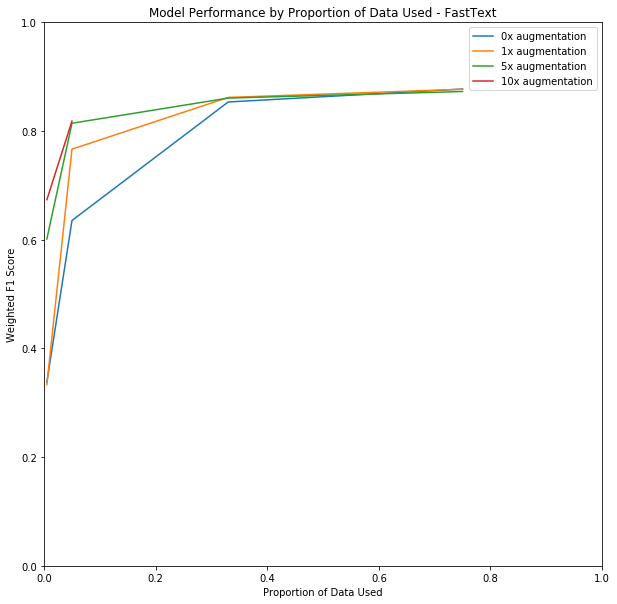

In [6]:
evaluate_model(FastText, X_train_valid, y_train_valid, FASTTEXT_GRID, PERCENT_MULTIPLIERS, w2v_augment_fn);

In [7]:
wn = WordNet()
    
def wn_augment_fn(X, times):
    return wn.augment(X, times=times, p=AUGMENT_PROBABILITY)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


[2019-08-24 20:26:25] Evaluating multiplier x0, percent 0.005 (125 obs)
[2019-08-24 20:27:50] Evaluating multiplier x1, percent 0.005 (250 obs)
[2019-08-24 20:29:10] Evaluating multiplier x5, percent 0.005 (750 obs)
[2019-08-24 20:30:32] Evaluating multiplier x10, percent 0.005 (1375 obs)
[2019-08-24 20:31:39] Evaluating multiplier x0, percent 0.05 (1250 obs)
[2019-08-24 20:33:26] Evaluating multiplier x1, percent 0.05 (2500 obs)
[2019-08-24 20:35:48] Evaluating multiplier x5, percent 0.05 (7500 obs)
[2019-08-24 20:38:37] Evaluating multiplier x10, percent 0.05 (13750 obs)
[2019-08-24 20:40:20] Evaluating multiplier x0, percent 0.33 (8250 obs)
[2019-08-24 20:46:06] Evaluating multiplier x1, percent 0.33 (16500 obs)
[2019-08-24 20:53:52] Evaluating multiplier x5, percent 0.33 (49500 obs)
[2019-08-24 20:57:07] Evaluating multiplier x0, percent 0.75 (18750 obs)
[2019-08-24 21:08:26] Evaluating multiplier x1, percent 0.75 (37500 obs)
[2019-08-24 21:26:06] Evaluating multiplier x5, percent 

,percent,multiplier,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy
0,0.005,0,0.333369,0.374980,0.49992,0.49992
1,0.005,1,0.333511,0.437480,0.49992,0.49992
2,0.005,5,0.602339,0.641561,0.61852,0.61852
3,0.005,10,0.669945,0.675624,0.67176,0.67176
4,0.050,0,0.678238,0.678501,0.67832,0.67832
5,0.050,1,0.766887,0.767742,0.76704,0.76704
6,0.050,5,0.805759,0.805764,0.80576,0.80576
7,0.050,10,0.805020,0.805166,0.80504,0.80504
8,0.330,0,0.852853,0.853568,0.85292,0.85292
9,0.330,1,0.861759,0.861771,0.86176,0.86176


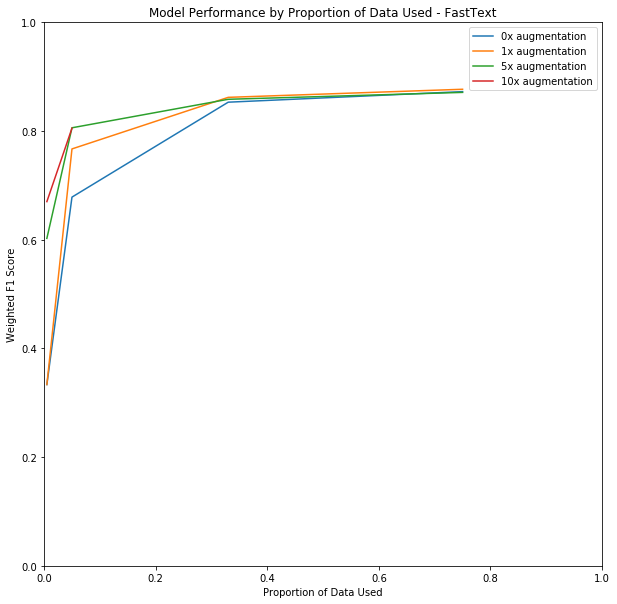

In [8]:
evaluate_model(FastText, X_train_valid, y_train_valid, FASTTEXT_GRID, PERCENT_MULTIPLIERS, wn_augment_fn);

In [9]:
bert = BERTMaskedLM(use_gpu=os.getenv("GOBBLI_USE_GPU") is not None)
bert.build()

def bert_augment_fn(X, times):
    return bert.augment(X, times=times, p=AUGMENT_PROBABILITY)

[2019-08-24 21:31:55] Evaluating multiplier x0, percent 0.005 (125 obs)
[2019-08-24 21:37:53] Evaluating multiplier x1, percent 0.005 (250 obs)
[2019-08-24 22:01:27] Evaluating multiplier x5, percent 0.005 (750 obs)
[2019-08-24 22:47:01] Evaluating multiplier x10, percent 0.005 (1375 obs)
[2019-08-24 22:48:17] Evaluating multiplier x0, percent 0.05 (1250 obs)
[2019-08-24 23:33:50] Evaluating multiplier x1, percent 0.05 (2500 obs)
[2019-08-25 03:15:04] Evaluating multiplier x5, percent 0.05 (7500 obs)
[2019-08-25 10:48:29] Evaluating multiplier x10, percent 0.05 (13750 obs)
[2019-08-25 10:50:31] Evaluating multiplier x0, percent 0.33 (8250 obs)
[2019-08-25 15:48:46] Evaluating multiplier x1, percent 0.33 (16500 obs)
[2019-08-26 16:09:49] Evaluating multiplier x5, percent 0.33 (49500 obs)
[2019-08-26 16:13:06] Evaluating multiplier x0, percent 0.75 (18750 obs)
[2019-08-27 03:20:28] Evaluating multiplier x1, percent 0.75 (37500 obs)
[2019-08-29 10:37:00] Evaluating multiplier x5, percent 

,percent,multiplier,Weighted F1 Score,Weighted Precision Score,Weighted Recall Score,Accuracy
0,0.005,0,0.333316,0.249990,0.49996,0.49996
1,0.005,1,0.333476,0.500000,0.50000,0.50000
2,0.005,5,0.614539,0.628695,0.62060,0.62060
3,0.005,10,0.670743,0.671907,0.67112,0.67112
4,0.050,0,0.659307,0.660962,0.65988,0.65988
5,0.050,1,0.771360,0.771362,0.77136,0.77136
6,0.050,5,0.811311,0.811381,0.81132,0.81132
7,0.050,10,0.815078,0.815095,0.81508,0.81508
8,0.330,0,0.854569,0.854899,0.85460,0.85460
9,0.330,1,0.862480,0.862482,0.86248,0.86248


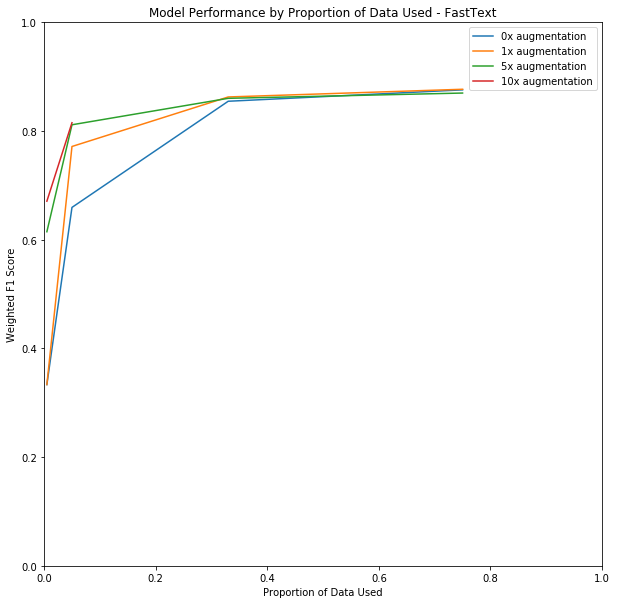

In [10]:
evaluate_model(FastText, X_train_valid, y_train_valid, FASTTEXT_GRID, PERCENT_MULTIPLIERS, bert_augment_fn);